In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from util.utilities import (
    temperature_scaled_mixing, 
    get_dataset,
    get_clf_data,
    one_hot_encode,
    explode_onehot_df,
    one_hot_encode,
    my_one_hot_encode,
    duplicates_1,
    duplicates_2,
    word_replace_dict,
    contact_labels
)

import pprint

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [2]:
df = get_dataset("case_data", drop_duplicates=False)

d:\cs\dacc\dacc-experimentation\notebooks\util\utilities.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(strs[name], **args)


In [3]:
# Most of these columns are unnecessary
print("Total entries: %d" % len(df.index))
print("Total notes: %d" % df.groupby("NOTEID").ngroups)

df = df[["NOTEID", "NOTE", "DESCRIPTION", "GROUPNAME"]]
df.astype({"NOTE": str})

df.drop_duplicates(inplace=True)
print("Total entries after removing cols and dropping dups.: %d" % len(df.index))
# NOTE, DO NOT DROP DUPLICATES USING NOTE, there are SEVERAL empty notes corresponding to different note ids!!!

print("Total notes: %d" % df.groupby("NOTEID").ngroups)

label_counts = df["DESCRIPTION"].value_counts()
all_labels = label_counts.index.to_numpy()
print("Num labels: %d" % len(all_labels))

Total entries: 108804
Total notes: 64385
Total entries after removing cols and dropping dups.: 108703
Total notes: 64385
Num labels: 113


In [4]:
print(label_counts)

Direct Contact                            38849
Collateral Contact                        24759
Client Contact out of office              12677
Client contact in office                  11446
Attempted client contact                   4278
                                          ...  
Client rejected by available providers        2
Medical detox not available                   2
HACA                                          1
Outpatient Treatment Program                  1
Denied                                        1
Name: DESCRIPTION, Length: 113, dtype: int64


**Contact Type Labels:**\
'Direct Contact', 'Collateral Contact', 'Client Contact out of office', 'Client contact in office', 'Attempted client contact', 'No Show', 'Direct Contact through Outreach', 'Attempted client contact through Outreach', 'Client contact', 'Client no show', 

**Labels without context:**\
'Other ', 'Other', 'Admitted', 'Date obtained', 'Date Received', 'Accepted ', 'Date Housed', 'Case Management', 'Accepted', 'Client left', 'Completed', 'Client declined', 'Denied ', 'Date Lost Housing', 'Program declined', 'Declined', 'Partial: Less than 1/2 or less than 45 days', 'Partial: More than 1/2 or over 45 days', 'Program Discharged', 'No beds available', 'Denied', 'Client Declined', 'Partial: More than 1/2', 'Partial: Less than 1/2', 'Denied            '

**Labels that might not have context:**\
'Axis I ', 'Detox'

**Duplicates**
- 'Client Contact': 'Direct Contact'
- 'No Show': 'Client no show'
- ...

There are some labels with the same use case that are worded differently, or have "artifacts" in their text. There are also labels which should be accompanied by a date. It's possible that the casenote date is the same as the date that these checkboxes are referring to, but it may not be necessary.  
Examples:
- 'No Show' vs. 'Client no show'
- 'Other ' vs. 'Other'
- "Accepted ' vs. 'Accepted'
- "Date Lost Housing" 

Context is missing for these. I think these are referring to being accepted into certain programs, and appear when those programs' checkboxes are checked. I think for future data collection, the dropdown checkboxes should be concatanated to the parent checkbox. More


In [5]:
contact_types = ['Direct Contact', 'Collateral Contact', 'Client Contact out of office', 'Client contact in office', 
                 'Attempted client contact', 'No Show', 'Direct Contact through Outreach', 
                 'Attempted client contact through Outreach']

no_context = ['Other ', 'Other', 'Admitted', 'Date obtained', 'Date Received', 'Accepted ', 'Date Housed', 
              'Case Management', 'Accepted', 'Client left', 'Completed', 'Client declined', 'Denied ', 
              'Date Lost Housing', 'Program declined', 'Declined', 'Partial: Less than 1/2 or less than 45 days', 
              'Partial: More than 1/2 or over 45 days', 'Program Discharged', 'No beds available', 'Denied', 
              'Client Declined', 'Partial: More than 1/2', 'Partial: Less than 1/2', 'Denied            ']

### Trying to identify duplicate labels with string overlap

This ended up not being useful because of the future discoveries about the nature of the data, but leaving here for documentation.

#### Basic String Overlap

In [6]:
# Automatic checking ot see if any strings overlap
# Very basic, just checking if any words of one string are in another

labels = [l for l in all_labels if l not in no_context]

sw = stopwords.words('english')
# These are generic words that may be in several unrelated checkboxes
# This list may be too long
ignore = ["client", "in", "of", "for", "contact", "through", "no", "not", 
          "date", "to", "services", "available", "due", "dacc", "mental", 
          "health", "treatment", "id", "at", "medical", "assessment"]

def get_label_lists(labels, ignore):
    label_lists = []
    for label in labels:
        temp_str = label.lower().strip()
        # Split on whitespace, /, and -
        label_list = re.split(r'\s|/|-', temp_str)
        label_list = [word for word in label_list 
                    if word not in ignore]
        label_lists.append(label_list)
    return label_lists

label_lists = get_label_lists(labels, sw + ignore)

In [7]:
overlaps = []
for i in range(len(label_lists)):
    l1 = label_lists[i]
    for j in range(i + 1, len(label_lists)):
        l2 = label_lists[j]

        # https://stackoverflow.com/questions/740287/how-to-check-if-one-of-the-following-items-is-in-a-list
        if [i for i in l1 if i in l2]:
            overlaps.append((i, j))

overlaps = [(labels[d[0]], labels[d[1]]) for d in overlaps]
ovdf = pd.DataFrame(overlaps, columns=["Word1", "Word2"])
# ovdf.to_csv("../data/checkboxes/overlaps_simple.csv")

# Inspect fully in text editor
ovdf

,Word1,Word2
0,Direct Contact,Direct Contact through Outreach
1,Client Contact out of office,Client contact in office
2,Attempted client contact,Attempted client contact through Outreach
3,No Show,Client no show
4,Direct Contact through Outreach,Attempted client contact through Outreach
...,...,...
71,Client assigned DACC CSR,Client not assigned DACC CSR due to court order
72,Denial of SSI/SSDI application,SSDI
73,Limited treatment access based on insurance status,Insufficient insurance coverage
74,Detox,Medical detox not available


#### Overlap with Cosine Similarity of Sentences

In [8]:
# Overlap by cosine similarity
# https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/

cosine_thresh = 0.5

# Don't use ignored list to exclude for cosine. It should take care of it
label_lists = get_label_lists(labels, sw)

overlaps = []
for i in range(len(label_lists)):
    l1 = set(label_lists[i])
    for j in range(i + 1, len(label_lists)):
        l2 = set(label_lists[j])
        
        rvector = l1.union(l2)
        
        # Vectors
        v1 = []
        v2 = []
        for w in rvector:
            val1 = 1 if w in l1 else 0
            val2 = 1 if w in l2 else 0

            v1.append(val1)
            v2.append(val2)
        
        c = 0
        for k in range(len(rvector)):
            c += v1[k] * v2[k]

        cosine = c / max(float((sum(v1) * sum(v2)) ** 0.5), 0.0000001)
        if cosine > cosine_thresh:
            overlaps.append((i, j))

# Makes copy pasting from csv easier
quoted_labels = [f"'{l}'" for l in labels]
overlaps = [(quoted_labels[d[0]], quoted_labels[d[1]]) for d in overlaps]
ovdf = pd.DataFrame(overlaps, columns=["Word1", "Word2"])
# ovdf.to_csv("../data/checkboxes/overlaps_cosine.csv")

ovdf

,Word1,Word2
0,'Direct Contact','Direct Contact through Outreach'
1,'Client Contact out of office','Client contact in office'
2,'Client Contact out of office','Attempted client contact'
3,'Client Contact out of office','Attempted client contact through Outreach'
4,'Client Contact out of office','Client contact'
5,'Client contact in office','Attempted client contact'
6,'Client contact in office','Attempted client contact through Outreach'
7,'Client contact in office','Client contact'
8,'Attempted client contact','Attempted client contact through Outreach'
9,'Attempted client contact','Client contact'


#### Duplicates
- More domain specific knowledge is needed for accurately identifying all duplicates
- Identified based on prior knowledge and looking mainly cosine overlap with thresh >0.5

**Duplicates Identified**
- 'Direct Contact','Direct Contact through Outreach'
- 'Attempted client contact','Attempted client contact through Outreach'
- 'No Show','Client no show'
- 'Criminal Background','Criminal background'
- 'SSI/SSDI','SSDI'

Some other thoughts: None for now

In [9]:
duplicates = [('Direct Contact','Direct Contact through Outreach'), 
              ('Attempted client contact','Attempted client contact through Outreach'), 
              ('No Show','Client no show'), 
              ('Criminal Background','Criminal background'), 
              ('SSI/SSDI','SSDI')]
# Need a method for assigning casenotes with one of these labels to the label with more examples 

### Exploring the GROUPNAME Column
This exploration made what I did above irrelevant. Should have done this first, because I discover that the labels in the Description column are of different *types* and those types are defined by the info in the GROUPNAME column. 

In [10]:
num_interv = df["GROUPNAME"].value_counts().drop(labels=["Team Check-In-->", "ID Documents-->"]).sum()
remaining = len(df.index) - num_interv

print("Interventions: ", num_interv)
print("Not Interventions: ", remaining)

df["GROUPNAME"].value_counts()

# There are WAY more non-interventions data.. we could just ignore this for now.
# However, that is largely due to how many direct and collateral contacts there are

Interventions:  7920
Not Interventions:  100783


Team Check-In-->                                                                        99247
ID Documents-->                                                                          1536
Mental Health-->Services obtained-->                                                      898
Income-->Income sought-->                                                                 888
Medical-->Received medical service-->                                                     743
Income-->Barriers-->                                                                      736
Housing-->Barriers-->                                                                     727
Substance abuse treatment-->                                                              546
Mental Health-->Crisis -->                                                                371
Income-->Income received-->                                                               352
Medical-->                                                  

So here's the deal. There is an "interventions" dataset which contains different interventions/initatives taken with clients. These interventions are also checkboxes, but the UI differentiates between the "regular" checkboxes, and the "interventions" checkboxes. In the GROUPNAME column, rows which contain "Team Check-In-->" and "ID Documents-->" Are the rows in which the description columns contain the regular checkbox data. The rows which contain other strings such as
- Medical-->Received medical service-->EMS Called-->
- Housing-->Permanent supportive housing-->VASH-->
- Substance abuse treatment-->Cenikor-->Not Completed-->
- Emergency Shelter-->
- Income-->Income received-->
- Mental Health-->Crisis -->

contain the interventions checkbox data, and the description columns for these rows contain the "last" checkbox clicked in the checkbox/dropdown hierarchy. So, there's a couple of things to note.
- Interventions checkboxes are hierarchical
- There are WAY more "regular" checkboxes than interventions checkboxes
  - Team checkin: 100783, All else: 7920
- There is a separate interventions dataset that we asked for after recognizing this issue. It can be found in box. 
  - This dataset does not contain any ids that overlap between the case-data dataset we have. It's main columns are
  - Intervention, Programs, Outcome, Program Start Date, Program Length, Length Unit, Program Status, Case Notes, Case Number
  - The "hierarchy" starts at intervention, and goes down to program status. We need to spend more time understanding this interventions data set, but I think for simplicity, we need to split the classification task up into two separate pieces. One for the regular team check in boxes, where the checkboxes/DESCRIPTION fields are generally contact types

In [11]:
leftover = df[df["GROUPNAME"].str.contains("Team Check-In-->|ID Documents-->")]["DESCRIPTION"].value_counts()
print(len(leftover))
leftover

28


Direct Contact                                                                  38849
Collateral Contact                                                              24759
Client Contact out of office                                                    12677
Client contact in office                                                        11446
Attempted client contact                                                         4278
No Show                                                                          1893
Legal Issues                                                                     1834
Direct Contact through Outreach                                                   833
Client Texas State ID                                                             769
Attempted client contact through Outreach                                         714
Client Birth certificate                                                          687
Release of information forms signed for all appropriat

So even now, there are a lot of duplicates. Based on convos with CMs, things like "Client contact out of office, ... in office, ... through outreach" are all duplicates. Yes that additional info might be useful, but the main info to record is direct contact. To simplify things further, let's assimilate the duplicates. Also, I realize that empty notes are of no use, so let's get rid of them.

Here is the final data cleaning method for processing data for our classification task

### Data Cleaning Method 1
- Remove empty notes
- Only keep Team Check-In--> and ID Documents--> labels (drop interventions)
- Map duplicate labels based on duplicates dict
```
duplicates = {
    "Direct Contact": ["Client contact in office", "Direct Contact through Outreach", "Client contact", "Client Contact out of office"],
    "Attempted client contact": ["Attempted client contact through Outreach", "Attempt to locate client"],
    "Client Assessment Conducted": ["New Client assessment completed"],
    "Coordinated Assessment Completed at DACC": ["Coordinated Assessment Completed through HOST contact"]
}
```

In [12]:
print("Total entries: %d" % len(df.index))

df = df[["NOTEID", "NOTE", "DESCRIPTION", "GROUPNAME"]]

df.drop_duplicates(inplace=True)

# Empty notes are of no use
df = df[df["NOTE"].str.strip().astype(bool)]
df['NOTE'] = df['NOTE'].replace('', np.nan)
df = df.dropna(subset=["NOTE"])

# Removing interventions checkboxes
cb_only = df[df["GROUPNAME"].str.contains("Team Check-In-->|ID Documents-->")]
cb_only = cb_only.drop("GROUPNAME", axis=1)
cb_only["DESCRIPTION"] = cb_only["DESCRIPTION"].astype("category")
cb_only = cb_only.sort_values(by="NOTEID")

# Combine the following. According to interviews with CMs, while they would 
# be fine with a dropdown for different types of Client Contact (in office, outreach, etc.)
# They all ultimately just refer to the same thing. 

# https://stackoverflow.com/questions/32262982/pandas-combining-multiple-categories-into-one

duplicates = {
    "Direct Contact": ["Client contact in office", "Direct Contact through Outreach", "Client contact", "Client Contact out of office"],
    "Attempted client contact": ["Attempted client contact through Outreach", "Attempt to locate client"],
    "Client Assessment Conducted": ["New Client assessment completed"],
    "Coordinated Assessment Completed at DACC": ["Coordinated Assessment Completed through HOST contact"]
}

mappings = pd.Series(duplicates).explode().sort_values()
mappings_dict = dict(zip(mappings.values, mappings.index))

# print(mappings_dict)

print("Total entries after magic: %d" % len(cb_only.index))
print("Total notes after magic: %d" % cb_only.groupby("NOTEID").ngroups)

cb_only["DESCRIPTION"] = cb_only["DESCRIPTION"].apply(lambda x: mappings_dict.get(x, x).strip())

# Need to to do this after mappings because there will be lots of dups
cb_only.drop_duplicates(inplace=True)

print("Total labels: %d" % len(cb_only["DESCRIPTION"].unique()))

cb_only["DESCRIPTION"].value_counts()

Total entries: 108703
Total entries after magic: 100745
Total notes after magic: 64040
Total labels: 20


Direct Contact                                                                  40430
Collateral Contact                                                              24743
Attempted client contact                                                         4946
No Show                                                                          1893
Legal Issues                                                                     1834
Client Texas State ID                                                             767
Client Birth certificate                                                          686
Release of information forms signed for all appropriate vendors and agencies      384
HMIS profile created/updated                                                      361
Client Assessment Conducted                                                       303
Coordinated Assessment Completed at DACC                                          294
Coordinated Assessment Scheduled at DACC              

<Axes: >

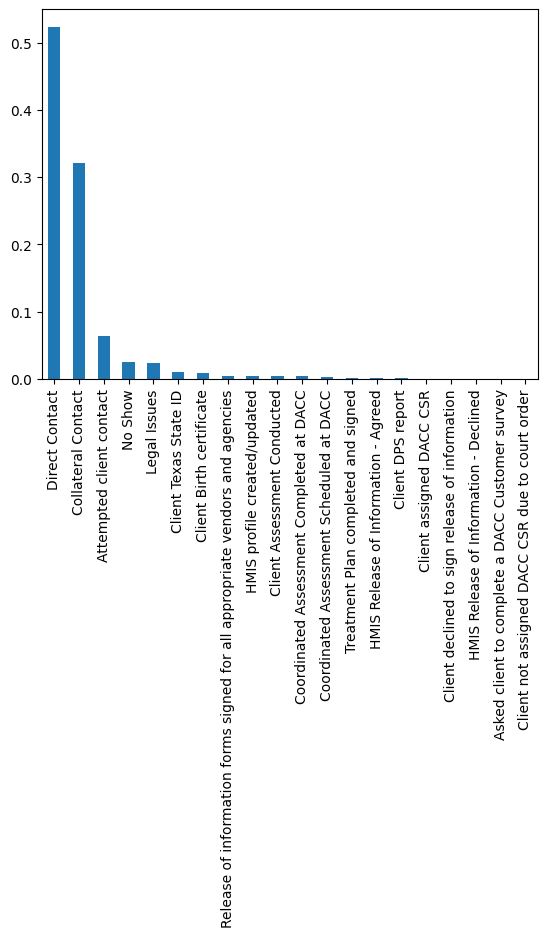

In [13]:
y_vals = cb_only["DESCRIPTION"].value_counts(normalize=True).tolist()
cb_only["DESCRIPTION"].value_counts(normalize=True).plot.bar()

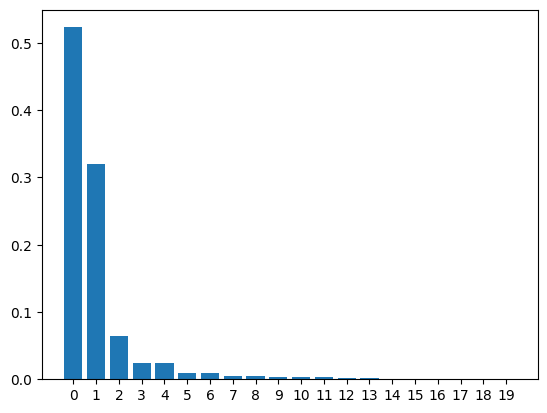

In [21]:
import matplotlib.pyplot as plt

plt.bar(x=range(0, 20), height=y_vals, tick_label=[str(i) for i in range(0, 20)])
plt.show()

Min Words: 1
Max Words: 1408
Average # characters in notes: 527.79
Average # words in notes: 92.42


count    77254.000000
mean        92.418749
std         89.180684
min          1.000000
25%         35.000000
50%         67.000000
75%        119.000000
max       1408.000000
Name: NOTE, dtype: float64

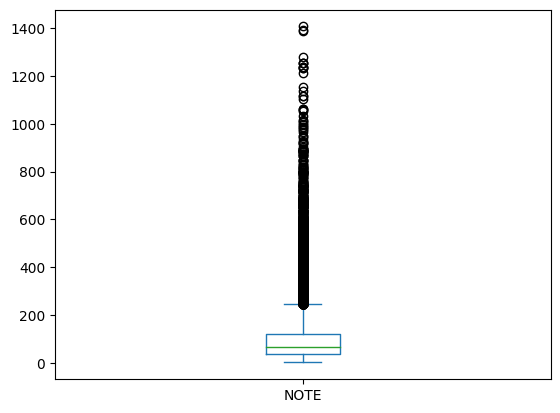

In [49]:
# Some stats about notes themselves
num_words = cb_only['NOTE'].apply(lambda x: len(x.split()))

num_words.plot.box()

print(f"Min Words: {num_words.min()}")
print(f"Max Words: {num_words.max()}")
print(f"Average # characters in notes: {cb_only['NOTE'].str.len().mean():.2f}")
print(f"Average # words in notes: {cb_only['NOTE'].str.split().map(len).mean():.2f}")

# Average note length is 92 so word token limit 128 isn't too bad. Will bump to 256.
num_words.describe()

### Error with onehot
After onehot encoding, number of labels doesn't add up to before onehot...

In [50]:
# For a dataframe with duplicate rows differing only in the label column,
# Returns the df with one hot encoded lists of the labels in label_col using MultiLabelBinarizer
# Duplicates are consolidated based on duplicate_id col,
# and the lists of labels for each data point are added to new_col
# List of labels are in alphabetical/sorted order, and dataframe is sorted by duplicate_id_col.

# Initially wrote one_hot_encode here, moved it to utilities and have been updating it there.

# df1 = get_clf_data(duplicate_labels_dict=duplicates_1)

# onehot_df, classes, binarzied, sorted_labels = one_hot_encode(df=df1, label_col="DESCRIPTION", new_col="LABELS", duplicate_id_col="NOTEID")
# onehot_df = onehot_df.drop("DESCRIPTION", axis=1)

# print(len(onehot_df.index))
# print(onehot_df.groupby("NOTEID").ngroups)

# onehot_df.head(1)

In [51]:
# # Manual check
# labels_lists = onehot_df["LABELS"].tolist()
# labels_lists = binarzied

# counts = [0] * len(classes)
# for ll in labels_lists:
#     counts += ll

# print("label counts of raw binarized data (by MLB)")
# pprint.pprint(dict(zip(classes, counts)))

# # This output matches explode output... problem is with onehot_encode
# # THE PROBLEM IS WITH MLB TRANSFORM

# # Yeah it's def with MLB. I'm sending the right number of labels to it. 
# print("label counts of label name lists I send to MLB")
# class_map = {label:i for i, label in enumerate(classes)}
# counts = [0] * len(classes)
# for labels in sorted_labels:
#     for label in labels:
#         counts[class_map[label]] += 1

# pprint.pprint(dict(zip(classes, counts)))

In [52]:
# Wrote my own binarizer
# onehot_df, classes = my_one_hot_encode(df=df1, label_col="DESCRIPTION", new_col="LABELS", duplicate_id_col="NOTEID")

# # Manual check
# labels_lists = np.array(onehot_df["LABELS"].tolist())

# print(labels_lists)
# counts = [0] * len(classes)
# for ll in labels_lists:
#     counts += ll

# print("label counts of raw binarized data (by MY binarizer)")
# pprint.pprint(dict(zip(classes, counts)))

#### Fixed it!
The issue was not with my binarizers aghhhh. I realized this because the binarizer that I wrote was doing the same. The issue was that after I mapped duplicate labels down to one label, there were now casenotes with duplicate checkboxes checked (duplicate DESCRIPTION values). These needed to be dropped in the preprocessing method after performing the duplicate label remapping. So it was the results AFTER onehot encoding which were correct and the ones without were too high and incorrect.

### Exploration after Classification Results

In [53]:
cb_only["DESCRIPTION"].value_counts(normalize=True).iloc[:2].sum()
# Direct and Collateral Contact make up 87.92% of the labels in the dataset.
# Idea 1. Get rid of all notes that contain ONLY direct contact or collateral contact 

from util.utilities import one_hot_encode

onehot_df, classes = one_hot_encode(cb_only, label_col="DESCRIPTION", new_col="LABELS", duplicate_id_col="NOTEID")

display(onehot_df.head(1))

dc_index = np.where(classes == "Direct Contact")[0][0]
dc_only_label = np.zeros(shape=len(classes), dtype=int)
dc_only_label[dc_index] = 1

cc_index = np.where(classes == "Collateral Contact")[0][0]
cc_only_label = np.zeros(shape=len(classes), dtype=int)
cc_only_label[cc_index] = 1

exclude = [dc_only_label, cc_only_label]

print(dc_only_label)
print(cc_only_label)

mask = onehot_df["LABELS"].apply(lambda x: np.array_equal(x, dc_only_label))
print("Direct Contact *only* labels", len(onehot_df[mask].index))

,NOTEID,NOTE,DESCRIPTION,LABELS
0,1485559,CL did not show up for appointment to complete CA.,No Show,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Direct Contact *only* labels 30867


In [54]:
mask = onehot_df["LABELS"].apply(lambda x: np.array_equal(x, cc_only_label))
print("Collateral Contact Only Labels", len(onehot_df[mask].index))

Collateral Contact Only Labels 17200


In [55]:
# Notes that have only direct and collateral contact checked.
# Removing this might not be a great idea 
dc_and_cc = np.add(dc_only_label, cc_only_label)
print(dc_and_cc)
mask = onehot_df["LABELS"].apply(lambda x: np.array_equal(x, dc_and_cc))
print(len(onehot_df[mask].index))

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
5391


In [56]:
mask = onehot_df["LABELS"].apply(lambda x: not (np.array_equal(x, dc_only_label) or np.array_equal(x, cc_only_label)))
exploded_df = onehot_df[mask].copy()
exploded_df = exploded_df.set_index("NOTEID")
print(len(exploded_df.index))

15973


In [57]:
from sklearn.preprocessing import MultiLabelBinarizer

def onehot_to_label_names(df, label_list_col, label_names):
    mlb = MultiLabelBinarizer()
    mlb.fit([label_names])

    label_names_lists = mlb.inverse_transform(np.stack(df[label_list_col].to_numpy()))
    return label_names_lists

# Make sure index is not an important ID column. i.e., reset index before using
def explode_onehot_df(df: pd.DataFrame, label_list_col, label_names, 
                      rename_col=None, label_names_list_col=None):

    if not isinstance(df[label_list_col].iloc[0], np.ndarray):
        print("ERROR: label_list_col must contain onehot encoded lists...")
        return df
    
    label_names_lists = onehot_to_label_names(df, label_list_col, label_names)

    df.reset_index(inplace=True)
    df[label_list_col] = pd.Series(label_names_lists)

    # For seeing all other labels checked on a note during qualitative analysis
    if label_names_list_col:
        df[label_names_list_col] = df[label_list_col]

    df = df.explode(label_list_col)

    if rename_col:
        df.rename({label_list_col: rename_col})

    return df

In [58]:
exploded_df = explode_onehot_df(exploded_df, "LABELS", classes)

print(len(exploded_df.index))
exploded_df["LABELS"].value_counts()
# exploded_df.head()

29187


Direct Contact                                                                  9563
Collateral Contact                                                              7543
Attempted client contact                                                        4946
No Show                                                                         1893
Legal Issues                                                                    1834
Client Texas State ID                                                            767
Client Birth certificate                                                         686
Release of information forms signed for all appropriate vendors and agencies     384
HMIS profile created/updated                                                     361
Client Assessment Conducted                                                      303
Coordinated Assessment Completed at DACC                                         294
Coordinated Assessment Scheduled at DACC                         

In [59]:
exploded_df["LABELS"].value_counts(normalize=True)

Direct Contact                                                                  0.327646
Collateral Contact                                                              0.258437
Attempted client contact                                                        0.169459
No Show                                                                         0.064858
Legal Issues                                                                    0.062836
Client Texas State ID                                                           0.026279
Client Birth certificate                                                        0.023504
Release of information forms signed for all appropriate vendors and agencies    0.013157
HMIS profile created/updated                                                    0.012369
Client Assessment Conducted                                                     0.010381
Coordinated Assessment Completed at DACC                                        0.010073
Coordinated Assessmen

Great! While we've removed a lot of data, there are still a lot of direct contacts. Moreover, direct and collateral contact can take a hit in precision because CMs already check them regularly.

### Qualitative Analysis of Each Label

I will have to omit the cell outputs for this section, but I am conducting a thorough review of each label. The ones with <= 20 notes, I'll just read all. For others, I will sample 20 notes. Going in ascending order of number of labeles

<Axes: >

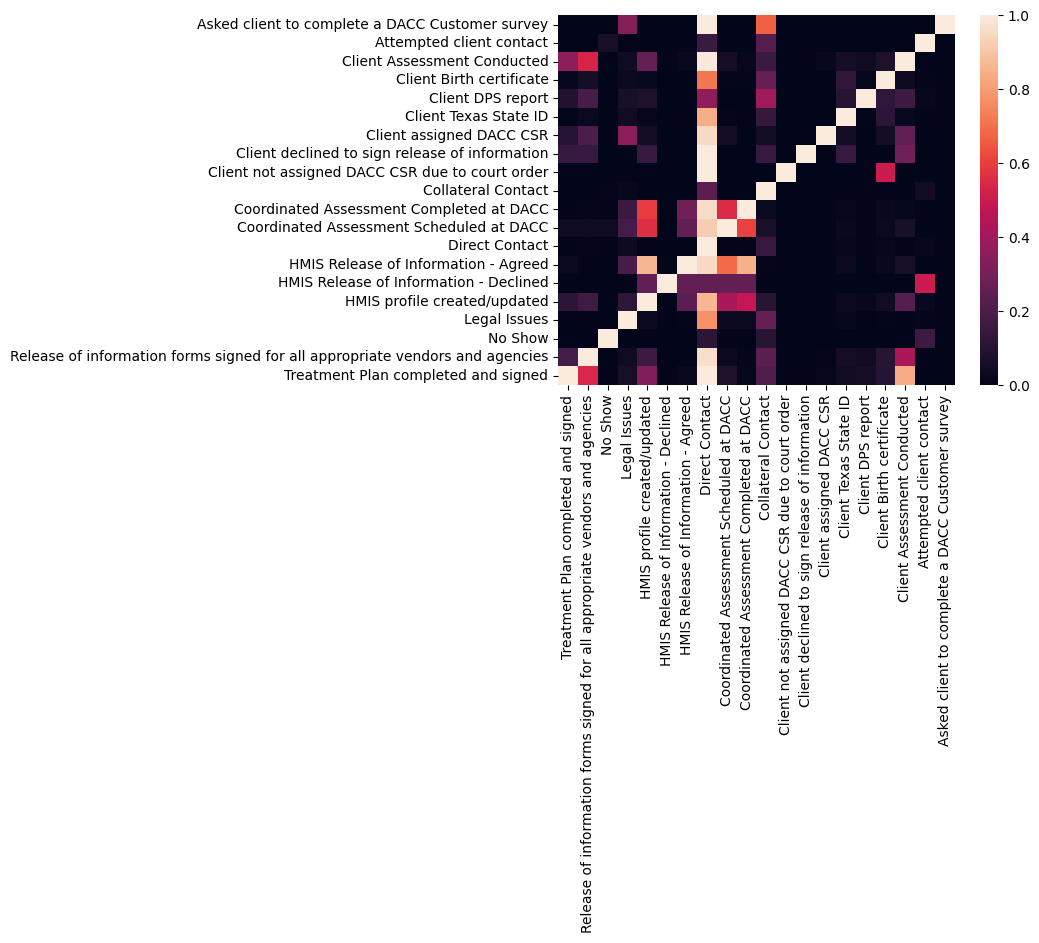

In [60]:
# Label occurence heatmap
label_lists = onehot_to_label_names(onehot_df, "LABELS", classes)
classes_rev = list(reversed(classes))

x_index_mappings = {label: i for i, label in enumerate(classes)}
y_index_mappings = {label: i for i, label in enumerate(classes_rev)}

cooccurences = np.zeros((len(classes), len(classes)))
for labels in label_lists:
    
    for label1 in labels:
        index1 = x_index_mappings[label1]
        for label2 in labels:
            index2 = y_index_mappings[label2]

            cooccurences[index1][index2] += 1

last_index = len(classes) - 1
for i in range(len(cooccurences)):
    cooccurences[i] /= cooccurences[i][last_index - i]

from seaborn import heatmap

heatmap(cooccurences,
        xticklabels=classes_rev,  
        yticklabels=classes, vmin=0.0, vmax=1.0)

In [61]:
thresh = 0.5

row_indicies, col_indicies = np.where(cooccurences >= thresh)

cooc_dict = dict()
print(f"Occur >= {thresh * 100}% of the time:")
for r, c in zip(row_indicies, col_indicies):

    if r != c:
        row = classes[r]
        col = classes_rev[c]

        if row not in cooc_dict.keys():
            cooc_dict[row] = []
        
        if row != col:
            cooc_dict[row].append(col)

for key, val in cooc_dict.items():
    print(key, ":", val)

Occur >= 50.0% of the time:
Asked client to complete a DACC Customer survey : ['Direct Contact', 'Collateral Contact']
Attempted client contact : []
Client Assessment Conducted : ['Release of information forms signed for all appropriate vendors and agencies', 'Direct Contact']
Client Birth certificate : ['Direct Contact']
Client DPS report : []
Client Texas State ID : ['Direct Contact']
Client assigned DACC CSR : ['Direct Contact']
Client declined to sign release of information : []
Client not assigned DACC CSR due to court order : ['Direct Contact', 'Client Birth certificate']
Collateral Contact : []
Coordinated Assessment Completed at DACC : ['HMIS profile created/updated', 'Direct Contact', 'Coordinated Assessment Scheduled at DACC']
Coordinated Assessment Scheduled at DACC : ['HMIS profile created/updated', 'Direct Contact', 'Coordinated Assessment Completed at DACC']
Direct Contact : []
HMIS Release of Information - Agreed : ['HMIS profile created/updated', 'Direct Contact', 'Coor

1. Direct contact occurs a lot everything 
2. Treatment Plan completed and signed occurs with Client Assessment conducted 
3. Coordinated Asssessment Scheduled and Completed occur 50% of th time

{'c0': 'Asked client to complete a DACC Customer survey',
 'c1': 'Attempted client contact',
 'c2': 'Client Assessment Conducted',
 'c3': 'Client Birth certificate',
 'c4': 'Client DPS report',
 'c5': 'Client Texas State ID',
 'c6': 'Client assigned DACC CSR',
 'c7': 'Client declined to sign release of information',
 'c8': 'Client not assigned DACC CSR due to court order',
 'c9': 'Collateral Contact',
 'c10': 'Coordinated Assessment Completed at DACC',
 'c11': 'Coordinated Assessment Scheduled at DACC',
 'c12': 'Direct Contact',
 'c13': 'HMIS Release of Information - Agreed',
 'c14': 'HMIS Release of Information - Declined',
 'c15': 'HMIS profile created/updated',
 'c16': 'Legal Issues',
 'c17': 'No Show',
 'c18': 'Release of information forms signed for all appropriate vendors and '
        'agencies',
 'c19': 'Treatment Plan completed and signed'}


<Axes: >

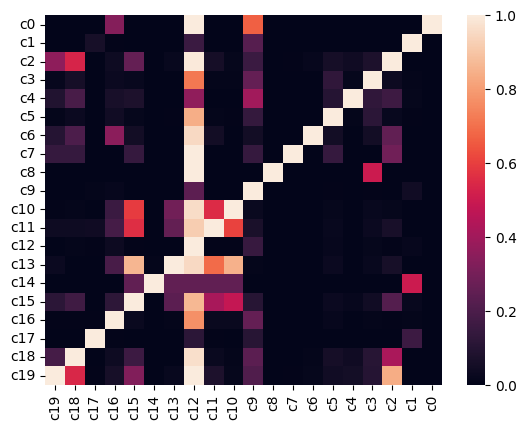

In [62]:
# For conciseness
yticks = [f"c{i}" for i in range(len(classes))]
xticks = list(reversed(yticks))

import pprint
pprint.pprint({l: classes[i] for i, l in enumerate(yticks)}, sort_dicts=False)

heatmap(cooccurences,
        xticklabels=xticks,  
        yticklabels=yticks, vmin=0.0, vmax=1.0)

In [ ]:
# Collateral contact ONLY. 
onehot_df[onehot_df["LABELS"].apply(lambda x: np.array_equal(x, cc_only_label))].sample(20)

In [ ]:
# Direct Contact ONLY
onehot_df[onehot_df["LABELS"].apply(lambda x: np.array_equal(x, dc_only_label))].sample(20)

In [ ]:
df = exploded_df

"""
Direct Contact                                                                  9563
Collateral Contact                                                              7543
Attempted client contact                                                        4946
No Show                                                                         1893
Legal Issues                                                                    1834
Client Texas State ID                                                            767
Client Birth certificate                                                         686
Release of information forms signed for all appropriate vendors and agencies     384
HMIS profile created/updated                                                     361
Client Assessment Conducted                                                      303
Coordinated Assessment Completed at DACC                                         294
Coordinated Assessment Scheduled at DACC                                         268
Treatment Plan completed and signed                                              129
HMIS Release of Information - Agreed                                             100
Client DPS report                                                                 80
Client assigned DACC CSR                                                          20
Client declined to sign release of information                                     7
HMIS Release of Information - Declined                                             4
Asked client to complete a DACC Customer survey                                    3
Client not assigned DACC CSR due to court order                                    2
"""

label = "Treatment Plan completed and signed"
random_state = 42
alt = 420

view = df[df["LABELS"] == label]
total_count = len(view.index)
if total_count > 20:
    view = view.sample(20, random_state=random_state)

print("LABEL: %s, View Count: %d, Total Count: %d" % (label, len(view.index), total_count))
display(view)

## Findings

#### Tl;dr, so now what?
- map words down to one word type
  - Need to decide what to map to:
  - cl: client, cl, clt
  - bc: bc, birth cert, birth certificate
  - tx id: tx id, texas id
  - cm: case manager, casemanager, writer, cm
  - ca: coordinated assessment, ca
  - ssc: ss, ssc
  - roi: release of information, rois
- Combine "CA scheduled" and "CA completed"
- Try 512 word tokens 
- Explain why contradictions set doesn't work
- Overall The data is not consistent and building a classifier from solely this data won't be effective
- Few shot training with note and labels crafted from patterns observed from samples could be useful. 
- Grouping labels into label types (ROI, CA, Assessment can be one type: intake), and then recommending label types
  - Entries can have multiple label types, and the labels can be of multiple types (ex. ROI in both intake and just its own thing too)
- Questions for CMs
  - Does intake paperwork include "Treatment Plan completed and signed?"
  - Is intake only for ICM? Or any walk-in client?
  - Should Client Assessment checkboxes also be consolidated?
  - Does an ROI have to be signed for a referral?

Full analysis in cb_label_analysis.md

### Data Cleaning Method 2
- Method 1 with updates
- Text preprocessing: map different ways of referring to same thing down to one word
- Remove all labels with only direct or collateral contact
- Also Try: remove all contact type labels (direct, collateral, attempted, no show)
- Updated duplicate labels dict
- I turned the method below into a general purpose preprocessing method with flags to control params. Will add this to utils.

In [64]:
import re

In [65]:
# Was thinking about removing stopwords or lemmatization, but I think 
# BERT needs the context from stopwords and tokenizer handles stemming.

# I'll keep a boolean that allows choosing between removing stopwords or not.
new_duplicates = {
    "Direct Contact": ["Client contact in office", "Direct Contact through Outreach", "Client contact", "Client Contact out of office"],
    "Attempted client contact": ["Attempted client contact through Outreach", "Attempt to locate client"],
    "Client Assessment Conducted": ["New Client assessment completed"],
    "Coordinated Assessment Completed at DACC": ["Coordinated Assessment Completed through HOST contact", "Coordinated Assessment Scheduled at DACC"],
    "Release of information forms signed for all appropriate vendors and agencies": ["Client declined to sign release of information"]

}

word_replace_dict = {
    "BC": ["birth cert", "birth certificate", "bc"],
    "TX ID": ["texas id", "tx id"],
    "_CM_": ["case manager", "casemanager", "writer", "cm"],
    "CM": ["_CM_", "this _CM_"],
    "CA": ["coordinated assessment"],
    "SSC": ["ss", "ssc"],
    "ROI": ["release of information", "rois"],
    "Client": ["cl", "client", "clt"],
}

contact_labels = ["Direct Contact", "Collateral Contact", "Attempted client contact", "No Show"]
bad_labels = ["Client not assigned DACC CSR due to court order",
              "Asked client to complete a DACC Customer survey",
              "HMIS Release of Information - Declined"]

def replace_words(text, word_replace_dict):
    for replacement, words in word_replace_dict.items():
        # \b is word boundary
        # https://stackoverflow.com/questions/54481198/what-is-a-better-way-to-match-multiple-substrings-in-a-string-than-to-search-for
        pat = r'\b({})\b'.format('|'.join(words))
        text = re.sub(pat, replacement, text, flags=re.IGNORECASE)
    return text

# Word_replace_dict values will be case ignorant.
# Turned this into a general purpose preprocessing method, added to utilities.
# Everytime I update there, I update here too.
def get_clf_data(drop_global_duplicates=False, remove_irrelvant_cols=True, drop_empty_notes=True, 
                 drop_interventions=True, duplicate_labels_dict=None, word_replace_dict=None, 
                 labels_to_ignore=None):

    df = get_dataset("case_data", drop_duplicates=drop_global_duplicates)
    print("Total initial entries: %d" % len(df.index))
    print("Total initial notes: %d" % df.groupby("NOTEID").ngroups)

    if remove_irrelvant_cols:
        df = df[["NOTEID", "NOTE", "DESCRIPTION", "GROUPNAME"]]
        df.drop_duplicates(inplace=True)
        print("- Removed irrelevant columns for checkbox classification, kept:", df.columns)

    # Empty notes are of no use
    if drop_empty_notes:
        df = df[df["NOTE"].str.strip().astype(bool)]
        df['NOTE'] = df['NOTE'].replace('', np.nan)
        df = df.dropna(subset=["NOTE"])
        print("- Dropped empty notes")

    # Removing interventions checkboxes
    if drop_interventions:
        df = df[df["GROUPNAME"].str.contains("Team Check-In-->|ID Documents-->")]
        df = df.drop("GROUPNAME", axis=1)
        df["DESCRIPTION"] = df["DESCRIPTION"].astype("category")
        df = df.sort_values(by="NOTEID")
        print("- Dropped interventions checkboxes")

    # Combine the following. According to interviews with CMs, while they would 
    # be fine with a dropdown for different types of Client Contact (in office, outreach, etc.)
    # They all ultimately just refer to the same thing. 

    # https://stackoverflow.com/questions/32262982/pandas-combining-multiple-categories-into-one

    if duplicate_labels_dict:
        mappings = pd.Series(duplicate_labels_dict).explode().sort_values()
        mappings_dict = dict(zip(mappings.values, mappings.index))
        df["DESCRIPTION"] = df["DESCRIPTION"].apply(lambda x: mappings_dict.get(x, x).strip())

        # After remapping, Make sure same checkbox is not checked twice for a note
        df.drop_duplicates(["NOTEID", "DESCRIPTION"], inplace=True)
        print("- Consolidated duplicate labels using the provided mappings.")

    if labels_to_ignore:
        df = df.loc[~df["DESCRIPTION"].isin(labels_to_ignore)]
        print("- Dropped entries containing the provided labels")
    
    if word_replace_dict:
        new_notes = df.set_index("NOTEID")["NOTE"].apply(lambda x: replace_words(x, word_replace_dict))
        df.set_index("NOTEID", inplace=True)
        df["NOTE"] = new_notes
        df.reset_index(inplace=True)
        print("- Substituted occurences of words in text with provided word mappings")

    print("Total labels: %d" % len(df["DESCRIPTION"].unique()))
    print("Total entries after preprocessing: %d" % len(df.index))
    print("Total notes after preprocessing: %d" % df.groupby("NOTEID").ngroups)

    return df.reset_index(drop=True)
    return df

# takes a while due to note text replacement
df = get_clf_data(duplicate_labels_dict=new_duplicates, 
                  word_replace_dict=word_replace_dict,
                  labels_to_ignore=contact_labels)
df.head(1)

d:\cs\dacc\dacc-experimentation\notebooks\util\utilities.py:25: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(strs[name], **args)


Total entries: 108804
Total labels: 15
Total entries after magic: 5278
Total notes after magic: 4106


,NOTEID,NOTE,DESCRIPTION
0,1485602,"Client walked in for on-call CM services. CM assisted Client in contacting the FL DMV to work on clearing CLs unpaid tickets. FL DMV rep. reports that Client must complete course at the DUI school. FL DMV rep. reports to complete this course out of state Client needs to contact Celeste Havis (1800-832-9623, 512-834-6628 ext. 2910). Once Client completes the course Client must mail certification, letter stating why Client completed out of state with CLs signature, copy of TX ID (proof of residency- ex. utility bill), schools phone number, agency license #, course information, state course was taken in. Client must also complete Advanced driver improvement school online (www.flhsmv.gov, search ADI, ticket # 12984py) to address Habitual Traffic Offender. Client must also mail a $280 money order/check made out to Motorist Services to BMC PO Box 5775 Tallahassee, FL 32314-5775. Client can also use a courier service to expedite process Back Track 850-878-54-37, 850-222-2666).",Client Texas State ID


<Axes: >

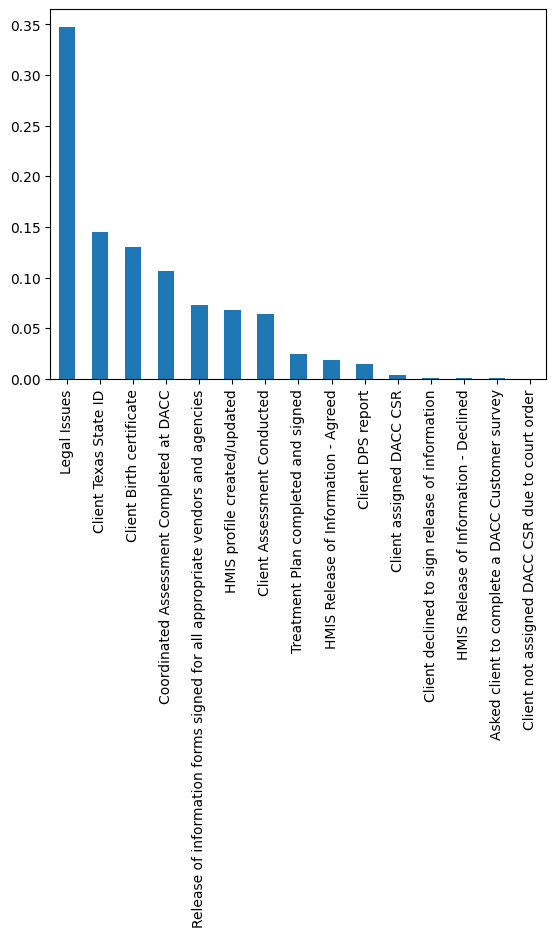

In [66]:
df["DESCRIPTION"].value_counts(normalize=True)
df["DESCRIPTION"].value_counts(normalize=True).plot.bar()

Min Words: 1
Max Words: 1234
Average # characters in notes: 609.57
Average # words in notes: 105.02


count    5278.000000
mean      105.017999
std        99.441555
min         1.000000
25%        39.000000
50%        76.000000
75%       137.000000
max      1234.000000
Name: NOTE, dtype: float64

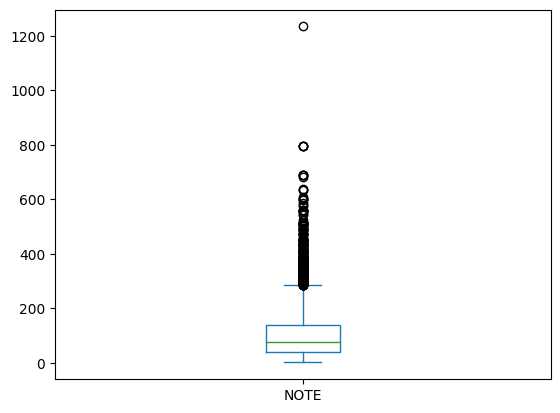

In [67]:
# Some stats about notes themselves
num_words = df['NOTE'].apply(lambda x: len(x.split()))

num_words.plot.box()

print(f"Min Words: {num_words.min()}")
print(f"Max Words: {num_words.max()}")
print(f"Average # characters in notes: {df['NOTE'].str.len().mean():.2f}")
print(f"Average # words in notes: {df['NOTE'].str.split().map(len).mean():.2f}")

# Average note length is 92 so word token limit 128 isn't too bad. Will bump to 256.
num_words.describe()

In [68]:
# making sure that onehot and explode_onehot are working correctly.
display(df["DESCRIPTION"].value_counts())

ohdf, classes = one_hot_encode(df, "DESCRIPTION", "LABELS", "NOTEID") 
explode_onehot_df(ohdf, "LABELS", classes)["LABELS"].value_counts()

# They are!

Legal Issues                                                                    1834
Client Texas State ID                                                            767
Client Birth certificate                                                         686
Coordinated Assessment Completed at DACC                                         562
Release of information forms signed for all appropriate vendors and agencies     384
HMIS profile created/updated                                                     361
Client Assessment Conducted                                                      339
Treatment Plan completed and signed                                              129
HMIS Release of Information - Agreed                                             100
Client DPS report                                                                 80
Client assigned DACC CSR                                                          20
Client declined to sign release of information                   

Legal Issues                                                                    1834
Client Texas State ID                                                            767
Client Birth certificate                                                         686
Coordinated Assessment Completed at DACC                                         399
Release of information forms signed for all appropriate vendors and agencies     384
HMIS profile created/updated                                                     361
Client Assessment Conducted                                                      303
Treatment Plan completed and signed                                              129
HMIS Release of Information - Agreed                                             100
Client DPS report                                                                 80
Client assigned DACC CSR                                                          20
Client declined to sign release of information                   

#### Few Shot Set
- Will defer this for future work on the project